In [1]:
!gpustat

blade                Tue Jun 15 15:39:34 2021  455.45.01
[0] RTX A6000        | 43'C,   0 % |     0 / 48685 MB |
[1] RTX A6000        | 64'C,  37 % | 44452 / 48685 MB | gkissas(44449M)
[2] RTX A6000        | 43'C,   0 % |     0 / 48685 MB |
[3] RTX A6000        | 38'C,   0 % |     0 / 48685 MB |
[4] RTX A6000        | 52'C,   4 % |     0 / 48685 MB |
[5] RTX A6000        | 25'C,   0 % | 44144 / 48685 MB | shyamss(44141M)
[6] RTX A6000        | 85'C,  99 % | 44150 / 48685 MB | shyamss(44147M)
[7] RTX A6000        | 85'C,  98 % | 47276 / 48685 MB | sifanw(47261M)


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import numpy as onp
from numpy import fft
import jax.numpy as np
from jax import random, grad, vmap, jit, lax
from jax.experimental import optimizers
from jax.experimental.optimizers import make_schedule
from jax.experimental.ode import odeint
from jax.nn import relu, leaky_relu, swish, sigmoid
from jax.config import config

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from jax import jacobian, eval_shape
from jax.tree_util import tree_map, tree_multimap, tree_reduce 
from jax.flatten_util import ravel_pytree
from jax.ops import index_update, index

from jaxpinns.optimizers import mdmm_adam

import neural_tangents as nt
import operator



from tqdm import trange, tqdm

import time
%matplotlib inline
from IPython.display import clear_output

In [4]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16,
                        'lines.linewidth': 2,
                        'axes.labelsize': 10,
                        'axes.titlesize': 16,
                        'xtick.labelsize': 10,
                        'ytick.labelsize': 10,
                        'legend.fontsize': 10,
                        'axes.linewidth': 2})

In [5]:
def MLP(layers, activation=np.tanh, off_set = 1., b_init = 0.):
  ''' Vanilla MLP with fan_in initialization'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = off_set / np.sqrt(d_in)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = b_init * np.ones(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = inputs@W + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = inputs@W + b
      return outputs
  return init, apply

In [6]:
def hidden_output(params, X, activation = np.tanh):
    '''
    params should be organized as ((w,b),...)
    '''
    inputs = X
    for W, b in params[:-1]:
        outputs = inputs@W + b
        inputs = activation(outputs)
        yield inputs
    W, b = params[-1]
    yield inputs@W + b

In [7]:
key = random.PRNGKey(int(time.time() * 100))

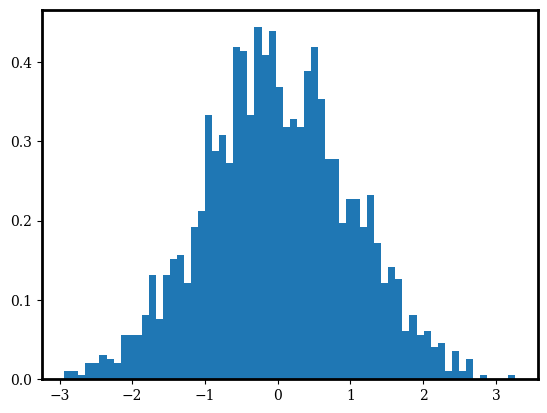

In [8]:
# X = random.uniform(key, shape = (2048, 1), minval = -np.sqrt(3), maxval = np.sqrt(3))
X = random.normal(key, shape = (2048, 1))
plt.figure()
h = plt.hist(X.flatten(), bins = 64, density = True)
plt.show()
plt.close()

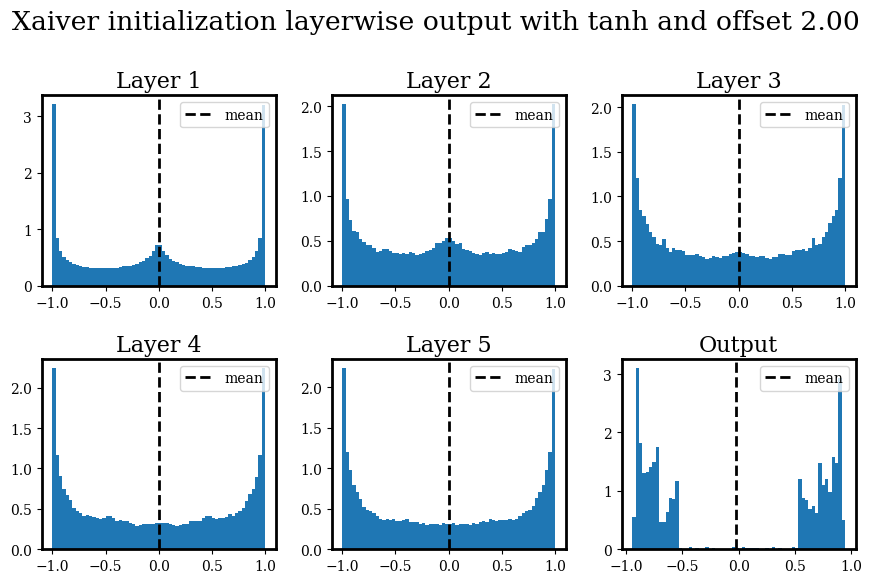

In [12]:
key,_ = random.split(key)
off_set = 2.
l = 6
layers = [1, *[1024 for _ in range(l-1)], 1]
activation = np.tanh
init_fn, _ = MLP(layers, activation = activation, off_set = off_set)
init_params = init_fn(key)
hidden_out = list(hidden_output(init_params, X, activation))

plt.figure(figsize = (9,6))
for i, out in enumerate(hidden_out):
    plt.subplot(2,l // 2,i + 1)
    plt.hist(out.flatten(), bins = 64, density = True)
    plt.axvline(out.flatten().mean(), linestyle= '--', color = 'k', label = 'mean')
#     plt.title(f'At layer {int(i + 1)}, std is {out.flatten().std():.2e}')
    if i < l - 1:
        plt.title(f'Layer {int(i + 1)}')
    else:
        plt.title(f'Output')
    plt.legend()
    plt.tight_layout()

plt.suptitle(f'Xaiver initialization layerwise output with {activation.__name__} and offset {off_set:.2f}')
plt.tight_layout()
plt.savefig(f'dist_trans_{int(off_set)}.pdf', dpi = 200)
plt.show()
plt.close()



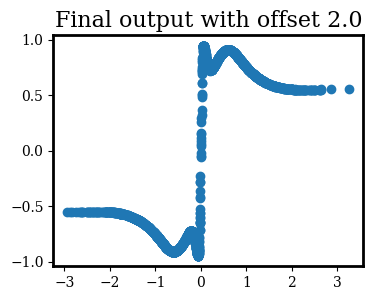

In [13]:
plt.figure(figsize = (4,3))
plt.scatter(X.flatten(), hidden_out[-1].flatten())
plt.title(f'Final output with offset {off_set:.1f}')
plt.savefig(f'init_out_{int(off_set)}.pdf', dpi = 200)
plt.show()

plt.close()

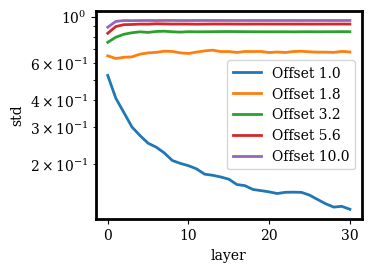

In [14]:
key,_ = random.split(key)
l = 32
layers = [1, *[1024 for _ in range(l-1)], 1]

plt.figure(figsize = (4,3))
for off_set in np.logspace(0,1,5):

    init_fn, _ = MLP(layers, activation = activation, off_set = off_set)
    init_params = init_fn(key)
    hidden_out = list(hidden_output(init_params, X, activation))
    layer_std = tree_map(np.std, hidden_out)

    plt.plot(layer_std[:-1], label = f'Offset {off_set:.1f}')

plt.xlabel('layer')
plt.yscale('log')
# plt.title(f'Xaiver initialization layerwise output std with {activation.__name__}')
plt.ylabel('std')
plt.legend()
plt.tight_layout()
plt.savefig(f'layers_std.pdf', dpi = 200)
plt.show()
plt.close()